In [1]:
# Importando as Bibliotecas. 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import date, datetime
from dateutil.relativedelta import relativedelta

In [2]:
# Lendo o arquivo csv extraído.
df = pd.read_csv('funcionarios_unique2.csv', encoding='latin-1')

In [3]:
# Renomeando a coluna 'Max(CodigoDependente)' para 'qtdDependentes'
df.rename(columns={'Max(CodigoDependente)':'qtdDependentes'},inplace=True)

In [4]:
# Retirando dados inconsistentes, que não contém a Data de Admissão.
df = df.loc[df.DataAdmissao != '-']

In [5]:
# Retirando a coluna FaixaTempoEmpresa, pois ela está com problemas está contando até o dia atual.
df.drop('FaixaTempoEmpresa',axis=1,inplace=True)

In [6]:
# Separando a Coluna 'ChaveLink' que contém as movimentações dos funcionários
df[['Empresa','ID_Funcionario']] = df.ChaveFuncionario.str.split('|',expand=True)
# Deletando a Coluna Chave Funcionário pois a mesma já foi separada junto com a coluna 'ChaveLink
del df['ChaveFuncionario']

In [7]:
# Adicionando a Coluna Situação para cada funcionário
df['Situacao'] = 'NaN'

In [8]:
# Colocando a situação dos funcionários no DataSet.
df.loc[(df.DataDesligamento == '-'), 'Situacao'] = 'Ativo'
df.loc[(df.DataDesligamento != '-'), 'Situacao'] = 'Desligado'

In [9]:
# Transformando as colunas para os formatos corretos.
df.DataAdmissao = pd.to_datetime(df.DataAdmissao, format='%Y-%m-%d')
df.DataNascimentoFuncionario = pd.to_datetime(df.DataNascimentoFuncionario, format='%Y-%m-%d')
df.DataDesligamento = pd.to_datetime(df.DataDesligamento, errors='coerce',format='%Y-%m-%d')
df.SalarioAtual = df.SalarioAtual.astype('float64')

In [10]:
# Adicionando coluna de tempo de empresa para cada funcionário.
df['TempoEmpresa'] = 'NaN'

In [11]:
# Adicionando coluna de tempo com a data de hoje para cada funcionário.
df['diaHoje'] = hoje = date.today()
df.diaHoje = pd.to_datetime(df.diaHoje,format='%Y-%m-%d')

In [12]:
# Adicionando o tempo de empresa real de cada funcionário, através da subtração do dia de hoje pela data de admissão em caso de funcionário 'Ativo'
df.loc[(df.Situacao == 'Ativo'), 'TempoEmpresa'] = df.diaHoje.subtract(df.DataAdmissao)
# Adicionando o tempo de empresa real de cada funcionário, através da subtração da data de desligamento pela data de admissão, quando funcionário foi
# desligado.
df.loc[(df.Situacao == 'Desligado'), 'TempoEmpresa'] = df.DataDesligamento.subtract(df.DataAdmissao)

In [13]:
# Transformando em 'timedelta' em dias, para posteriormente converter em anos . 
df.TempoEmpresa = pd.to_timedelta(df.TempoEmpresa,'D')

In [14]:
# Reclassificando a situação dos colaboradores, como funcionários com data de desligamento superior a 1 ano são considerados
# 'Desligado_SemTurnover' e funcionários com desligamento abaixo disso 'Desligado_ComTurnover'.
df.loc[(df.DataDesligamento-df.DataAdmissao)>= pd.Timedelta(366,'d'), 'Situacao'] = 'Desligado_SemTurnover'
df.loc[(df.DataDesligamento-df.DataAdmissao)<= pd.Timedelta(365,'d'), 'Situacao'] = 'Desligado_ComTurnover'

In [15]:
# Retirando dados de funcionários desligados sem turnover, pois não são relevantes para esse caso.
tirar = (df.loc[df.Situacao == 'Desligado_SemTurnover'])
df.drop(tirar.index,inplace=True)

In [16]:
# Verificando as colunas e os valores das mesmas para criar um dicionário de dados.
df.columns,[df.Empresa.unique(),df.FaixaSalarial.unique(),df.EstadoCivilFuncionario.unique(),df.GrauInstrucao.unique(),
df.FuncionarioSindicalizado.unique(),df.RecebeInsalubridade.unique(),df.RecebePericulosidade.unique(),df.qtdDependentes.unique(),
df.Situacao.unique(),df.CargaHorariaFuncionario.unique()]

(Index(['DataAdmissao', 'DataDesligamento', 'SalarioAtual', 'SexoFuncionario',
        'DataNascimentoFuncionario', 'EstadoCivilFuncionario', 'GrauInstrucao',
        'CidadeFuncionario', 'BairroFuncionario', 'FuncionarioSindicalizado',
        'RecebeInsalubridade', 'RecebePericulosidade',
        'CargaHorariaFuncionario', 'FaixaSalarial', 'qtdDependentes', 'Empresa',
        'ID_Funcionario', 'Situacao', 'TempoEmpresa', 'diaHoje'],
       dtype='object'),
 [array(['101', '103', '201', '701', '702', '703'], dtype=object),
  array(['De  03 Até 04 Salário Mínimo', 'De  01 Até 02 Salário Mínimo',
         'De  05 Até 06 Salário Mínimo', 'De  02 Até 03 Salário Mínimo',
         'De  15 Até 20 Salário Mínimo', 'De  08 Até 09 Salário Mínimo',
         'De  04 Até 05 Salário Mínimo', 'De  07 Até 08 Salário Mínimo',
         'De  10 Até 11 Salário Mínimo', 'Acima  20 Salário Mínimo',
         'De  09 Até 10 Salário Mínimo', 'De  14 Até 15 Salário Mínimo',
         'De  06 Até 07 Salário Míni

In [17]:
# Transformando os dados categóricos em númericos para a análise (manualmente).
cargaHoraria = {'220':0,'200':1,'180':2,'100':3,'60':4,'30':5}
df.CargaHorariaFuncionario = df.CargaHorariaFuncionario.replace(cargaHoraria)
situacao = {'Ativo':0,'Desligado_ComTurnover':1,'Desligado_SemTurnover':2}
df.Situacao = df.Situacao.replace(situacao)
sexoFuncionario = {'Masculino':0,'Feminino':1}
df.SexoFuncionario = df.SexoFuncionario.replace(sexoFuncionario)
estadoCivilFuncionario = {'Casado':0, 'Solteiro':1, 'Viúvo':2, 'Divorciado':3,
        'Separado Judicialmente':4, 'União Estável':5, 'Desquitado':6, 'Outros':7}
df.EstadoCivilFuncionario = df.EstadoCivilFuncionario.map(estadoCivilFuncionario)
grauInstrucaoFuncionario = {'Ensino Medio Completo':6, '5ª/8ª Ensino Fundamental':3,
        '4ª completa Ensino Fundamental':2, 'Superior Completo - Pós Gradua':10,
        '4ª serie incompleta Ensino Fun':1, 'Ensino Medio Incompleto':5,
        'Ensino Fundamental Completo':4, 'Técnico':7, 'Superior Incompleto':8,
        'Analfabeto':0, 'Superior Completo':9}
df.GrauInstrucao = df.GrauInstrucao.replace(grauInstrucaoFuncionario)
funcionarioSindicalizado = {'Não Sindicalizado':0, 'Sindicalizado':1}
df.FuncionarioSindicalizado = df.FuncionarioSindicalizado.replace(funcionarioSindicalizado)
insalubre = {'Não Recebe':0, 'Recebe':1}
df.RecebeInsalubridade = df.RecebeInsalubridade.replace(insalubre)
periculosidade = {'Não Recebe':0, 'Recebe':1}
df.RecebePericulosidade = df.RecebePericulosidade.replace(periculosidade)
cargaHoraria = {'220':0, '180':2, '125':3, '200':1, '100':4, '60':5, '30':6}
df.CargaHorariaFuncionario = df.CargaHorariaFuncionario.replace(cargaHoraria)
empresaFuncionario = {'101':0, '103':1, '201':2, '701':3, '702':4, '703':5}
df.Empresa = df.Empresa.replace(empresaFuncionario)
dependentesFuncionario = {'-':0}
df.qtdDependentes = df.qtdDependentes.replace(dependentesFuncionario)
faixaSalarialFuncionario = {'Até 01 Salário Mínimo':0,'De  01 Até 02 Salário Mínimo':1,'De  02 Até 03 Salário Mínimo':2,
 'De  03 Até 04 Salário Mínimo':3,'De  04 Até 05 Salário Mínimo':4,'De  05 Até 06 Salário Mínimo':5,
 'De  06 Até 07 Salário Mínimo':6,'De  07 Até 08 Salário Mínimo':7,'De  08 Até 09 Salário Mínimo':8,
 'De  09 Até 10 Salário Mínimo':9,'De  10 Até 11 Salário Mínimo':10, 'De  11 Até 12 Salário Mínimo':11,
 'De  12 Até 13 Salário Mínimo':12, 'De  13 Até 14 Salário Mínimo':13,'De  14 Até 15 Salário Mínimo':14,
 'De  15 Até 20 Salário Mínimo':15,  'Acima  20 Salário Mínimo':16}
df.FaixaSalarial = df.FaixaSalarial.replace(faixaSalarialFuncionario)

In [18]:
# Incluindo a cidade da empresa.
df['Cidade_Empresa'] = 'NaN'
df.loc[(df.Empresa == 0), 'Cidade_Empresa'] = 'Palmas-PR'
df.loc[(df.Empresa == 3), 'Cidade_Empresa'] = 'Cacador-SC'
df.loc[(df.Empresa == 1), 'Cidade_Empresa'] = 'Santa_Cecilia-SC'
df.loc[(df.Empresa == 5), 'Cidade_Empresa'] = 'CD Pernambuco-PE'
df.loc[(df.Empresa == 2), 'Cidade_Empresa'] = 'Palmas-PR'
df.loc[(df.Empresa == 4), 'Cidade_Empresa'] = 'Curitiba-PR'

In [19]:
# Transformando os dados das cidades em códigos categóricos.
cidadesEmpresa = {'Palmas-PR':0, 'Santa_Cecilia-SC':1, 'Cacador-SC':2, 'Curitiba-PR':3,
       'CD Pernambuco-PE':4}
df.Cidade_Empresa = df.Cidade_Empresa.replace(cidadesEmpresa)

In [20]:
# Verificando o nome das cidades dos funcionários para validar se serão usadas.
listaCidades = df.CidadeFuncionario.unique()
listaCidades.sort()
listaCidades

array(['ABELARDO LUZ', 'AGUA DOCE', 'AGUDOS', 'ARAPOTI', 'BAURU',
       'BITURUNA', 'CACADOR', 'CALMON', 'CAMPINAS', 'CAMPO BELO DO SUL',
       'CAMPO DO TENENTE', 'CAMPO ERE', 'CAMPOS NOVOS', 'CANTAGALO',
       'CASCAVEL', 'CASTRO', 'CATANDUVAS', 'CAÇADOR',
       'CEL DOMINGOS SOARES', 'CERRO AZUL', 'CLEVELANDIA',
       'CORONEL DOMINGO SOARES', 'CORONEL DOMINGOS SOARES',
       'CORREIA PINTO', 'CRUZ MACHADO', 'CURITIBA', 'CURITIBANOS',
       'Cacador', 'Caçador', 'Coronel Domingos Soares', 'FAXINAL DO CEU',
       'FAZENDA RIO GRANDE', 'FRAIBURGO', 'GEERAL CARNEIRO',
       'GENERAL CARNEIRO', 'GLORINHA', 'GRAVATAI', 'GUARAPUAVA',
       'GUARATUBA', 'IMBAU', 'IMBITUVA', 'INACIO MARTINS', 'IPABA',
       'IPATINGA', 'IPERO', 'IPIRANGA', 'IPOJUCA', 'IRANI',
       'IRIONOPOLIES', 'ITAPERUCU', 'ITAPETININGA', 'ITAPEVA', 'ITARARE',
       'JABOATAO DOS GUARARAPES', 'LAGES', 'LAPA', 'LARANJEIRAS DO SUL',
       'LEBOM REGIS', 'LEBON REGIS', 'LENCOIS PAULISTA', 'LONDRINA',
       '

In [21]:
# Criando um dicionário para padronizar os nomes das cidades.
mapeamento = {'ABELARDO LUZ':'ABELARDO_LUZ', 'AGUA DOCE':'AGUA_DOCE', 'AGUDOS':'AGUDOS', 'ARAPOTI':'ARAPOTI', 'BAURU':'BAURU',
       'BITURUNA':'BITURUNA', 'CACADOR':'CACADOR', 'CACADOTR':'CACADOR', 'CALMON':'CALMON', 'CAMPINAS':'CAMPINAS',
       'CAMPO BELO DO SUL':'CAMPO_BELO_DO_SUL', 'CAMPO DO TENENTE':'CAMPO_DO_TENENTE', 'CAMPO ERE':'CAMPO_ERE',
       'CAMPOS NOVOS':'CAMPOS_NOVOS', 'CANTAGALO':'CANTAGALO', 'CASCAVEL':'CASCAVEL', 'CASTRO':'CASTRO', 'CATANDUVAS':'CATANDUVAS',
       'CAÇADOR':'CACADOR', 'CEL DOMINGOS SOARES':'CEL_DOMINGOS_SOARES', 'CERRO AZUL':'CERRO_AZUL', 'CLEVELANDIA':'CLEVELANDIA',
       'COLOMBO':'COLOMBO', 'CORONEL DOMINGO SOARES':'CEL_DOMINGOS_SOARES', 'CORONEL DOMINGOS SOARES':'CEL_DOMINGOS_SOARES',
       'CORREIA PINTO':'CORREIA_PINTO', 'CRUZ MACHADO':'CRUZ_MACHADO', 'CURITIBA':'CURITIBA', 'CURITIBANOS':'CURITIBANOS',
       'Cacador':'CACADOR', 'Caçador':'CACADOR', 'Coronel Domingos Soares':'CEL_DOMINGOS_SOARES', 'DR ULYSSES':'DOUTOR_ULYSSES',
       'FAXINAL DO CEU':'FAXINAL_DO_CEU', 'FAZENDA RIO GRANDE':'FAZENDA_RIO_GRANDE', 'FRAIBURGO':'FRAIBURGO',
       'GEERAL CARNEIRO':'GEN_CARNEIRO', 'GENERAL CARNEIRO':'GEN_CARNEIRO', 'GLORINHA':'GLORINHA', 'GRAVATAI':'GRAVATAI',
       'GUAIBA':'GUAIBA', 'GUARAPUAVA':'GUARAPUAVA', 'GUARATUBA':'GUARATUBA', 'IMBAU':'IMBAU', 'IMBITUVA':'IMBITUVA',
       'INACIO MARTINS':'INACIO_MARTINS', 'IPABA':'IPABA', 'IPATINGA':'IPATINGA', 'IPERO':'IPERO', 'IPIRANGA':'IPIRANGA',
       'IPOJUCA':'IPOJUCA', 'IRANI':'IRANI', 'IRATI':'IRATI', 'IRIONOPOLIES':'IRENEOPOLIS', 'ITAPERUCU':'ITAPERUCU',
       'ITAPETININGA':'ITAPETININGA', 'ITAPEVA':'ITAPEVA', 'ITARARE':'ITARARE', 'JABOATAO DOS GUARARAPES':'JABOATAO_DOS_GUARARAPES',
       'JOINVILLE':'JOINVILLE', 'JUIZ DE FORA':'JUIZ_DE_FORA', 'JUQUITIBA':'JUQUITIBA', 'LAGES':'LAGES', 'LAPA':'LAPA',
       'LARANJEIRAS DO SUL':'LARANJEIRAS_DO_SUL', 'LEBOM REGIS':'LEBON_REGIS', 'LEBON REGIS':'LEBON_REGIS', 'LEBON REGS':'LEBON_REGIS',
       'LENCOIS PAULISTA':'LENCOIS_PAULISTA', 'LONDRINA':'LONDRINA', 'LUZERNA':'LUZERNA', 'MALLEI':'MALLET', 'MALLET':'MALLET',
       'MANGUEIRINHA':'MANGUEIRINHA', 'MARACAS':'MARACAS', 'MARCILIANO FERNANDES':'MARCILIANO_FERNANDES', 'MARIOPOLIS':'MARIOPOLIS',
       'MARQUINHO':'MARQUINHO', 'MATOS COSTA':'MATOS_COSTA', 'MONTE  CASTELO':'MONTE_CASTELO', 'MONTE CARLO':'MONTE_CARLO',
       'MONTE CASTELO':'MONTE_CASTELO', 'MUCURI':'MUCURI', 'Mirassol':'MIRASSOL', 'NOVA LARANJEIRA':'NOVA_LARANJEIRAS',
       'NOVA LARANJEIRAS':'NOVA_LARANJEIRAS', 'NOVAS LARANJEIRAS':'NOVA_LARANJEIRAS', 'OTACILIO COSTA':'OTACILIO_COSTA',
       'P0ALMAS':'PALMAS', 'PALMAS':'PALMAS', 'PALMEIRINHA':'PALMEIRINHA', 'PALMITAL':'PALMITAL', 'PASSOS MAIA':'PASSOS_MAIA',
       'PATO BRANCO':'PATO_BRANCO', 'PIEN':'PIEN', 'PINHA':'PINHAIS', 'PINHAIS':'PINHAIS', 'PINHAO':'PINHAO', 'PINHÃO':'PINHAO',
       'PIRAI DO SUL':'PIRAI_DO_SUL', 'PIRAIBA DO SUL':'PIRAIBA_DO_SUL', 'PIRAÍ DO SUL':'PIRAI_DO_SUL', 'PONTA GROSSA':'PONTA_GROSSA',
       'PONTE ALTA':'PONTE_ALTA', 'PONTE ALTA DO NORTE':'PONTE_ALTA_DO_NORTE', 'PONTE SERRADA':'PONTE_SERRADA',
       'PORTO UNIAO':'PORTO_UNIAO', 'POTIM':'POTIM', 'PRESIDENTE PRUDENTE':'PRESIDENTE_PRUDENTE', 'QUEDAS DO IGUACU':'QUEDAS_DO_IGUACU',
       'QUITANDINHA':'QUITANDINHA', 'RANCHARIA':'RANCHARIA', 'RIALMA':'RIALMA', 'RIO AZUL':'RIO_AZUL',
       'RIO BRANCO DO SUL':'RIO_BRANCO_DO_SUL', 'RIO DAS ANTAS':'RIO_DAS_ANTAS', 'RIO DE JANEIRO':'RIO_DE_JANEIRO',
       'RIO DO CAMPO':'RIO_DO_CAMPO', 'RIO DO SUL':'RIO_DO_SUL', 'RIO NEGRINHO':'RIO_NEGRINHO', 'RIO NEGRO':'RIO_NEGRO',
       'Rio Bonito do Iguaçu':'RIO_BONITO_DO_IGUACU', 'SALVADOR':'SALVADOR', 'SANTA  CECILIA':'SANTA_CECILIA',
       'SANTA CECIILIA':'SANTA_CECILIA', 'SANTA CECILI':'SANTA_CECILIA', 'SANTA CECILIA':'SANTA_CECILIA',
       'SANTA CECILIA SC':'SANTA_CECILIA', 'SANTA CECIlia':'SANTA_CECILIA', 'SANTA CECLIA':'SANTA_CECILIA',
       'SANTA CECÍLIA':'SANTA_CECILIA', 'SANTA CEILIA':'SANTA_CECILIA', 'SAO BENTO DO SUL':'SAO_BENTO_DO_SUL',
       'SAO CRISTOVAO':'SAO_CRISTOVAO_DO_SUL', 'SAO CRISTOVAO DO SUIL':'SAO_CRISTOVAO_DO_SUL', 'SAO CRISTOVAO DO SUL':'SAO_CRISTOVAO_DO_SUL',
       'SAO JOSE DO CERRITO':'SAO_JOSE_DO_CERRITO', 'SAO JOSE DOS PINHAIS':'SAO_JOSE_DOS_PINHAIS', 'SAO LEOPOLDO':'SAO_LEOPOLDO',
       'SAO PAULO':'SAO_PAULO', 'São Cristovão do Sul':'SAO_CRISTOVAO_DO_SUL', 'TELEMACO BORBA':'TELEMACO_BORBA',
       'TIMBO GRANDE':'TIMBO_GRANDE', 'TRES BARRAS':'TRES_BARRAS', 'TURVO':'TURVO', 'UNIAO DA VITORIA':'UNIAO_DA_VITORIA',
       'UNIAO DA VITÓRIA':'UNIAO_DA_VITORIA', 'VENTANIA':'VENTANIA', 'VIDEIRA':'VIDEIRA', 'Videira':'VIDEIRA'}

In [22]:
# Substituindo o nome antigo pelo nome padrão
df.CidadeFuncionario = df.CidadeFuncionario.map(mapeamento)

In [23]:
# Conferindo os nomes das cidades.
df.CidadeFuncionario.unique()

array(['PALMAS', 'CLEVELANDIA', 'CEL_DOMINGOS_SOARES', 'GEN_CARNEIRO',
       'BITURUNA', 'TELEMACO_BORBA', 'LAPA', 'CACADOR', 'PASSOS_MAIA',
       'PALMEIRINHA', 'LEBON_REGIS', 'CALMON', 'INACIO_MARTINS', 'PINHAO',
       'IRANI', 'CATANDUVAS', 'UNIAO_DA_VITORIA', 'TURVO', 'TIMBO_GRANDE',
       'MONTE_CARLO', 'CANTAGALO', 'GUARAPUAVA', 'FAXINAL_DO_CEU',
       'PINHAIS', 'CERRO_AZUL', 'ITAPERUCU', 'CASTRO', 'ITARARE',
       'MATOS_COSTA', 'RIO_BRANCO_DO_SUL', 'IPIRANGA', 'ITAPEVA',
       'RIALMA', 'MANGUEIRINHA', 'RIO_NEGRO', 'ARAPOTI', 'IMBAU',
       'SAO_JOSE_DO_CERRITO', 'MALLET', 'IMBITUVA', 'MARACAS', 'MUCURI',
       'IPABA', 'CURITIBA', 'MARIOPOLIS', 'LONDRINA', 'ABELARDO_LUZ',
       'GUARATUBA', 'VENTANIA', 'FAZENDA_RIO_GRANDE', 'MIRASSOL',
       'LENCOIS_PAULISTA', 'IPERO', 'SANTA_CECILIA',
       'SAO_CRISTOVAO_DO_SUL', 'RIO_BONITO_DO_IGUACU',
       'PONTE_ALTA_DO_NORTE', 'MARCILIANO_FERNANDES', 'IRENEOPOLIS',
       'PONTE_ALTA', 'CORREIA_PINTO', 'RIO_DO_CAMPO', 'MO

In [24]:
# Criando um dataSet com as variáveis que serão usadas .
data = df[['Empresa', 'Cidade_Empresa',
       'SalarioAtual', 'SexoFuncionario','qtdDependentes',
       'EstadoCivilFuncionario', 'GrauInstrucao',
       'FuncionarioSindicalizado', 'RecebeInsalubridade',
       'RecebePericulosidade', 'CargaHorariaFuncionario','Situacao']]

In [25]:
# Verificando as informações do DataSet.
data.info(),data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5344 entries, 12 to 19349
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Empresa                   5344 non-null   int64  
 1   Cidade_Empresa            5344 non-null   int64  
 2   SalarioAtual              5344 non-null   float64
 3   SexoFuncionario           5344 non-null   int64  
 4   qtdDependentes            5344 non-null   object 
 5   EstadoCivilFuncionario    5344 non-null   int64  
 6   GrauInstrucao             5344 non-null   int64  
 7   FuncionarioSindicalizado  5344 non-null   int64  
 8   RecebeInsalubridade       5344 non-null   int64  
 9   RecebePericulosidade      5344 non-null   int64  
 10  CargaHorariaFuncionario   5344 non-null   int64  
 11  Situacao                  5344 non-null   int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 542.8+ KB


(None,
            Empresa  Cidade_Empresa   SalarioAtual  SexoFuncionario  \
 count  5344.000000     5344.000000    5344.000000      5344.000000   
 mean      1.039858        0.803144    1978.518125         0.256737   
 std       1.085224        0.746682    3389.186036         0.436874   
 min       0.000000        0.000000     405.000000         0.000000   
 25%       0.000000        0.000000    1091.200000         0.000000   
 50%       1.000000        1.000000    1547.300000         0.000000   
 75%       1.000000        1.000000    1896.280000         1.000000   
 max       5.000000        4.000000  126111.850000         1.000000   
 
        EstadoCivilFuncionario  GrauInstrucao  FuncionarioSindicalizado  \
 count             5344.000000    5344.000000               5344.000000   
 mean                 1.291168       4.730352                  0.413174   
 std                  1.453821       1.945757                  0.492450   
 min                  0.000000       0.000000       

In [26]:
# Transformando os dados de dependentes em inteiro.
data.qtdDependentes = data.qtdDependentes.astype('int64')

D:\ProgramFiles\Anaconda\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [27]:
# Verificando a correlação entre os dados de entrada e a variável alvo
data.corr()

,Empresa,Cidade_Empresa,SalarioAtual,SexoFuncionario,qtdDependentes,EstadoCivilFuncionario,GrauInstrucao,FuncionarioSindicalizado,RecebeInsalubridade,RecebePericulosidade,CargaHorariaFuncionario,Situacao
Empresa,1.000000,0.931494,0.121329,-0.050800,-0.016305,-0.045555,0.254067,0.156193,0.036246,0.086476,0.236732,-0.014579
Cidade_Empresa,0.931494,1.000000,0.096371,-0.032654,-0.065858,0.005398,0.268508,0.306244,0.035269,0.073620,0.240412,0.001595
SalarioAtual,0.121329,0.096371,1.000000,-0.074788,0.175919,-0.095546,0.265337,-0.102636,-0.012245,0.079862,-0.102099,-0.219602
SexoFuncionario,-0.050800,-0.032654,-0.074788,1.000000,0.023668,0.042292,0.055915,-0.104285,0.138045,-0.080841,0.141317,-0.019833
qtdDependentes,-0.016305,-0.065858,0.175919,0.023668,1.000000,-0.027311,-0.070866,-0.109442,0.023336,0.060088,-0.059921,-0.217932
EstadoCivilFuncionario,-0.045555,0.005398,-0.095546,0.042292,-0.027311,1.000000,-0.121570,0.179101,0.002673,-0.054517,-0.088609,0.104484
GrauInstrucao,0.254067,0.268508,0.265337,0.055915,-0.070866,-0.121570,1.000000,-0.061063,-0.025120,0.152262,0.076733,-0.098792
FuncionarioSindicalizado,0.156193,0.306244,-0.102636,-0.104285,-0.109442,0.179101,-0.061063,1.000000,-0.035736,-0.023939,-0.111598,0.138640
RecebeInsalubridade,0.036246,0.035269,-0.012245,0.138045,0.023336,0.002673,-0.025120,-0.035736,1.000000,-0.013605,-0.061687,-0.015359
RecebePericulosidade,0.086476,0.073620,0.079862,-0.080841,0.060088,-0.054517,0.152262,-0.023939,-0.013605,1.000000,-0.023550,-0.098011


In [28]:
# Verificando se existem dados nulos no dataSet
data.isnull().sum()

Empresa                     0
Cidade_Empresa              0
SalarioAtual                0
SexoFuncionario             0
qtdDependentes              0
EstadoCivilFuncionario      0
GrauInstrucao               0
FuncionarioSindicalizado    0
RecebeInsalubridade         0
RecebePericulosidade        0
CargaHorariaFuncionario     0
Situacao                    0
dtype: int64

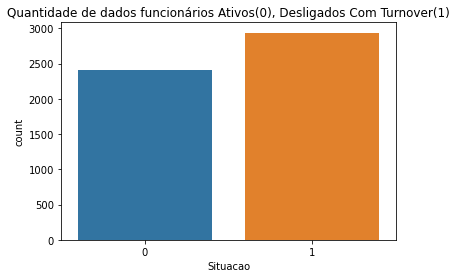

In [29]:
# Plotando um gráfico para verificar a quantidade de dados de funcionários ativos e desligados.
sns.countplot(x='Situacao',data=data)
plt.title('Quantidade de dados funcionários Ativos(0), Desligados Com Turnover(1)')
plt.show()

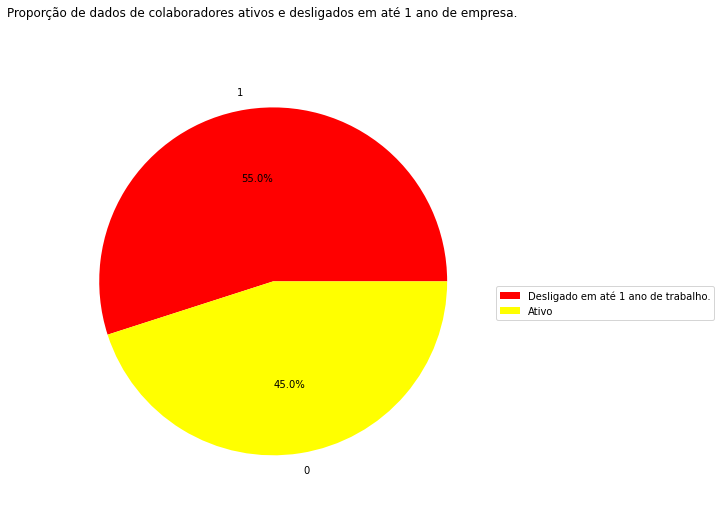

In [30]:
# Plotando a proporção de dados de Ativos|Inativos na empresa.
rotulos = df['Situacao'].value_counts().index
cores = ['red','yellow','blue']
valores = df['Situacao'].value_counts().values
plt.figure(figsize=(12,8))
plt.pie(valores,labels=rotulos,colors=cores,autopct='%1.1f%%')
plt.suptitle('Proporção de dados de colaboradores ativos e desligados em até 1 ano de empresa.')
plt.legend(['Desligado em até 1 ano de trabalho.','Ativo'],loc='best',bbox_to_anchor=(1,0.5))
plt.show()

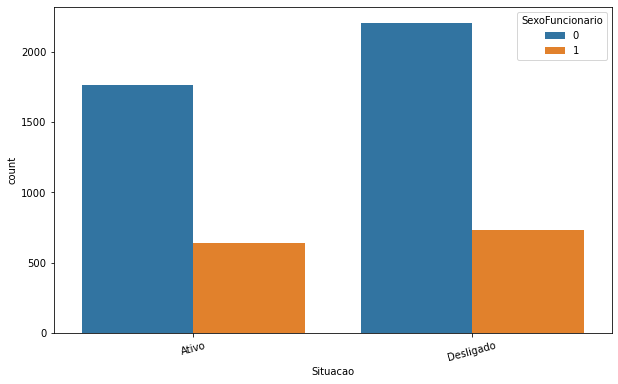

In [31]:
# Verificando a situação por gênero, onde 0 é Ativo e 1 é Desligado com menos de um ano de empresa.
fig,ax = plt.subplots(figsize=(10,6))
sns.countplot(x=df['Situacao'], hue=df['SexoFuncionario'])
ax.set_xticklabels(['Ativo','Desligado'])
plt.xticks(rotation=15)
plt.show()

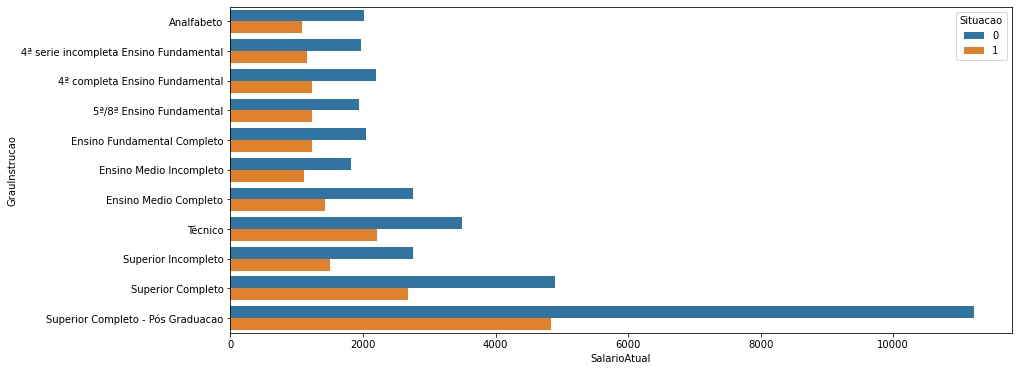

In [32]:
# Validando situação em relação ao Salário e Grau de Instrução.
fig, ax = plt.subplots(figsize=(14,6))
sns.barplot(y='GrauInstrucao',x='SalarioAtual',hue='Situacao',data=df,orient='h',ci=False)
ax.set_yticklabels(['Analfabeto','4ª serie incompleta Ensino Fundamental','4ª completa Ensino Fundamental','5ª/8ª Ensino Fundamental',
        'Ensino Fundamental Completo','Ensino Medio Incompleto','Ensino Medio Completo', 'Técnico','Superior Incompleto', 
         'Superior Completo','Superior Completo - Pós Graduacao'])
plt.show()

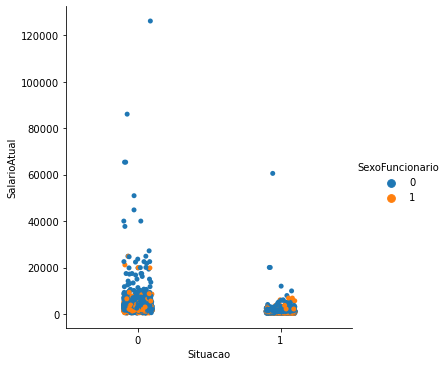

In [33]:
# Verificando Situação em relação ao Salário e Sexo do Funcionário.
sns.catplot(x='Situacao',y='SalarioAtual',hue='SexoFuncionario',data=df)
plt.show()

In [34]:
# Retirando a variável alvo dos dados a serem previstos.
from sklearn.model_selection import train_test_split
X = data.drop(['Situacao'],axis=1).values
y = data.Situacao.values

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score,KFold,StratifiedKFold,cross_validate
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
#import lazypredict
#from lazypredict.Supervised import LazyClassifier
import xgboost as xgb
SEED = 42
np.random.seed(SEED)
X_treino,X_teste,y_treino,y_teste = train_test_split(X,y,test_size=0.33, random_state=SEED)

In [36]:
# Usando KFold para a mistura dos dados de treino . 
cv = KFold(n_splits=5,shuffle=True)

In [37]:
# Passando e treinando os modelos de Machine Learning . 
modelo_svc = SVC()
modeloFlorestaAleatoria = RandomForestClassifier(n_estimators=3)
modeloArvoreDecisao = DecisionTreeClassifier(max_depth=2)
modeloRegressaoLogistica = LogisticRegression(solver='liblinear',max_iter=50)
modeloNaiveBayes = GaussianNB()
modeloXGB = xgb.XGBClassifier(use_label_encoder=False,eval_metric='rmse')
modelosTeste = [modeloRegressaoLogistica, modeloFlorestaAleatoria, modeloArvoreDecisao, modeloNaiveBayes, modelo_svc, modeloXGB]
nome = ['Regressão Logística', 
         'Floresta Aleatória','Arvore Decisão','Naive Bayes','Modelo SVC','Modelo Reforço de Gradiente']
np.random.seed(SEED)
#cv = StratifiedKFold(n_splits = 5, shuffle = True)
cont = 0
for item in modelosTeste:
    
    resultados = cross_val_score(item, X_treino, y_treino, cv = cv, 
                              scoring = 'accuracy')
    media = resultados.mean()
    desvioPadrao = resultados.std()
    print('Acurácia média - Modelo {}: {:.2f}%'
          .format(nome[cont], media*100))
    print('Intervalo de acurácia - Modelo {}: [{:.2f}% ~ {:.2f}%]\n'
           .format(nome[cont], 
                  (media - 2*desvioPadrao)*100, (media + 2*desvioPadrao)*100))
    cont += 1

Acurácia média - Modelo Regressão Logística: 79.08%
Intervalo de acurácia - Modelo Regressão Logística: [76.62% ~ 81.54%]

Acurácia média - Modelo Floresta Aleatória: 90.25%
Intervalo de acurácia - Modelo Floresta Aleatória: [88.83% ~ 91.67%]

Acurácia média - Modelo Arvore Decisão: 89.39%
Intervalo de acurácia - Modelo Arvore Decisão: [88.42% ~ 90.35%]

Acurácia média - Modelo Naive Bayes: 65.36%
Intervalo de acurácia - Modelo Naive Bayes: [63.49% ~ 67.24%]

Acurácia média - Modelo Modelo SVC: 87.18%
Intervalo de acurácia - Modelo Modelo SVC: [85.22% ~ 89.13%]

Acurácia média - Modelo Modelo Reforço de Gradiente: 93.10%
Intervalo de acurácia - Modelo Modelo Reforço de Gradiente: [91.23% ~ 94.98%]



Feature_num:0 | Nome_feature: Empresa | Feature_importance :  9.10%
Feature_num:1 | Nome_feature: Cidade_Empresa | Feature_importance :  7.82%
Feature_num:2 | Nome_feature: SalarioAtual | Feature_importance :  29.52%
Feature_num:3 | Nome_feature: SexoFuncionario | Feature_importance :  8.10%
Feature_num:4 | Nome_feature: qtdDependentes | Feature_importance :  4.03%
Feature_num:5 | Nome_feature: EstadoCivilFuncionario | Feature_importance :  3.89%
Feature_num:6 | Nome_feature: GrauInstrucao | Feature_importance :  3.57%
Feature_num:7 | Nome_feature: FuncionarioSindicalizado | Feature_importance :  5.08%
Feature_num:8 | Nome_feature: RecebeInsalubridade | Feature_importance :  1.11%
Feature_num:9 | Nome_feature: RecebePericulosidade | Feature_importance :  2.36%
Feature_num:10 | Nome_feature: CargaHorariaFuncionario | Feature_importance :  25.41%


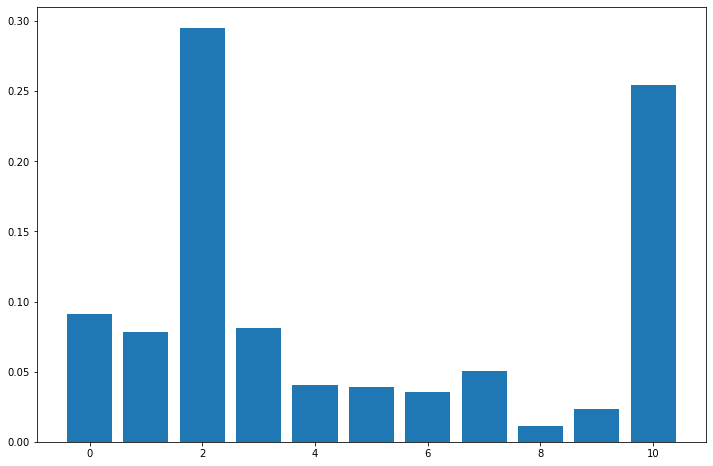

In [38]:
# Calculando a importância das features para auxiliar na engenharia de recursos.
modeloXGB.fit(X_treino,y_treino,eval_metric='rmse')
importancia = modeloXGB.feature_importances_
for i,v in enumerate(importancia):
    nome = data.columns[i]
    print('Feature_num:{} | Nome_feature: {} | Feature_importance :  {:.2f}%'.format(i,nome,v*100))
# Plotando a Feature importance
plt.figure(figsize=(12,8))
plt.bar([x for x in range(len(importancia))], importancia)
plt.show()

In [39]:
data.columns

Index(['Empresa', 'Cidade_Empresa', 'SalarioAtual', 'SexoFuncionario',
       'qtdDependentes', 'EstadoCivilFuncionario', 'GrauInstrucao',
       'FuncionarioSindicalizado', 'RecebeInsalubridade',
       'RecebePericulosidade', 'CargaHorariaFuncionario', 'Situacao'],
      dtype='object')

In [40]:
# Criando função para determinar a precisão do modelo.
def intervalo_precisao(resultados):
    media = resultados.mean()
    desvioPadrao = resultados.std()
    print('Precisão média: {:.2f}%'.format(media*100))
    print('Intervalo de Precisão: [{:.2f}% ~ {:.2f}%]'
          .format((media - 2*desvioPadrao)*100, (media + 2*desvioPadrao)*100))
np.random.seed(SEED)
cv = StratifiedKFold(n_splits = 5, shuffle = True)
modeloFlorestaAleatoria = RandomForestClassifier(n_estimators=3)
resultados = cross_val_score(modeloFlorestaAleatoria, X_treino, y_treino, cv = cv, 
                          scoring='precision_weighted')
intervalo_precisao(resultados)

Precisão média: 90.53%
Intervalo de Precisão: [88.58% ~ 92.48%]


In [41]:
# Criando função para determinar o Recall do modelo.
def intervalo_precisao(resultados):
    media = resultados.mean()
    desvioPadrao = resultados.std()
    print('Recall médio: {:.2f}%'.format(media*100))
    print('Intervalo de Recall: [{:.2f}% ~ {:.2f}%]'
          .format((media - 2*desvioPadrao)*100, (media + 2*desvioPadrao)*100))
np.random.seed(SEED)
cv = StratifiedKFold(n_splits = 5, shuffle = True)
modeloFlorestaAleatoria = RandomForestClassifier(n_estimators=3)
resultados = cross_val_score(modeloFlorestaAleatoria, X_treino, y_treino, cv = cv, 
                          scoring='recall')
intervalo_precisao(resultados)

Recall médio: 89.32%
Intervalo de Recall: [85.67% ~ 92.97%]


In [42]:
# Criando função para determinar a precisão do modelo.
def intervalo_precisao(resultados):
    media = resultados.mean()
    desvioPadrao = resultados.std()
    print('Precisão média: {:.2f}%'.format(media*100))
    print('Intervalo de Precisão: [{:.2f}% ~ {:.2f}%]'
          .format((media - 2*desvioPadrao)*100, (media + 2*desvioPadrao)*100))
np.random.seed(SEED)
cv = StratifiedKFold(n_splits = 5, shuffle = True)
modeloXGB = xgb.XGBClassifier(use_label_encoder=False,eval_metric='rmse')
resultados = cross_val_score(modeloXGB, X_treino, y_treino, cv = cv, 
                          scoring='precision_weighted')
intervalo_precisao(resultados)

Precisão média: 93.82%
Intervalo de Precisão: [92.40% ~ 95.24%]


In [43]:
# Criando função para determinar a Recall do modelo.
def intervalo_precisao(resultados):
    media = resultados.mean()
    desvioPadrao = resultados.std()
    print('Recall médio: {:.2f}%'.format(media*100))
    print('Intervalo de Recall: [{:.2f}% ~ {:.2f}%]'
          .format((media - 2*desvioPadrao)*100, (media + 2*desvioPadrao)*100))
np.random.seed(SEED)
cv = StratifiedKFold(n_splits = 5, shuffle = True)
modeloXGB = xgb.XGBClassifier(use_label_encoder=False,eval_metric='rmse')
resultados = cross_val_score(modeloXGB, X_treino, y_treino, cv = cv, 
                          scoring='recall')
intervalo_precisao(resultados)

Recall médio: 91.33%
Intervalo de Recall: [89.10% ~ 93.56%]


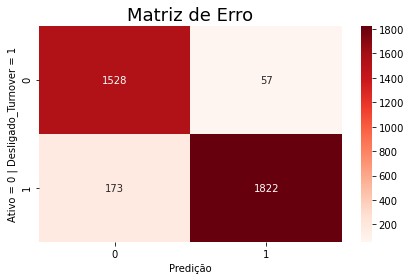

In [44]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
np.random.seed(SEED)
cv = StratifiedKFold(n_splits = 5, shuffle = True)
model = xgb.XGBClassifier(use_label_encoder=False,eval_metric='rmse')
y_pred = cross_val_predict(model, X_treino, y_treino, cv = cv)
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_treino, y_pred), annot=True, 
            ax=ax, fmt='d', cmap='Reds')
ax.set_title("Matriz de Erro", fontsize=18)
ax.set_ylabel("Ativo = 0 | Desligado_Turnover = 1")
ax.set_xlabel("Predição")
plt.tight_layout()

In [45]:
# Validando os melhores hiperparâmetros para o modelo.
#from sklearn.model_selection import RandomizedSearchCV
#params = { 'max_depth': [3, 5, 6, 10, 15, 20],
#           'learning_rate': [0.01, 0.1, 0.2, 0.3],
#           'subsample': np.arange(0.5, 1.0, 0.1),
#           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
#           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
#           'n_estimators': [100, 500, 1000]}
#xgbr = xgb.XGBRegressor(seed = 20)
#clf = RandomizedSearchCV(estimator=xgbr,
#                         param_distributions=params,
#                         scoring='neg_mean_squared_error',
#                         n_iter=25,
#                         verbose=1)
#clf.fit(X_treino, y_treino)
#print("Melhores parâmetros:", clf.best_params_)
#print("Mais baixo Erro Quadrático Médio: ", (-clf.best_score_)**(1/2.0))

In [46]:
modelo_final = xgb.XGBClassifier(random_state=SEED,max_depth=3,learning_rate=0.3,subsample=0.79999,
                                colsample_bytree=0.6,colsample_bylevel=0.89,use_label_encoder=False,eval_metric='rmse')
modelo_final.fit(X_treino, y_treino)
y_pred = modelo_final.predict(X_teste)
# imprimindo relatório de classificação
print("Relatório de Classificação:\n", 
       classification_report(y_teste, y_pred, digits=2))

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92       822
           1       0.96      0.89      0.93       942

    accuracy                           0.92      1764
   macro avg       0.92      0.93      0.92      1764
weighted avg       0.93      0.92      0.92      1764



In [47]:
modelo_final.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.89,
 'colsample_bynode': 1,
 'colsample_bytree': 0.6,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.3,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.79999,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'rmse'}

In [48]:
#from sklearn.externals import joblib
#joblib.dump(modeloFlorestaAleatoria_final, 'modelo.pkl')

In [49]:
import joblib
joblib.dump(modelo_final, 'modeloXGB_binary.pkl')

['modeloXGB_binary.pkl']